# Unit Normalization, Time Alignment, Resampling, and Windowing for Longitudinal Data

This notebook covers essential preprocessing techniques for longitudinal medical data, including unit normalization, time alignment, resampling, and windowing. These techniques are crucial for preparing time-series medical data for analysis and integration across different sources and measurement systems.

First, let's import the necessary libraries for working with time-series data and create some synthetic longitudinal medical data to demonstrate the concepts.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

Now we'll create synthetic longitudinal medical data representing different patients with measurements taken at irregular intervals. This simulates real-world scenarios where data collection frequency varies.

In [2]:
# Create synthetic longitudinal data for 3 patients
def create_patient_data(patient_id, start_date, n_days, measurement_frequency):
    dates = []
    current_date = start_date
    
    while current_date <= start_date + timedelta(days=n_days):
        if np.random.random() < measurement_frequency:
            dates.append(current_date)
        current_date += timedelta(hours=6)  # Check every 6 hours
    
    n_measurements = len(dates)
    
    # Simulate different vital signs with different units and scales
    data = {
        'patient_id': [patient_id] * n_measurements,
        'timestamp': dates,
        'heart_rate_bpm': np.random.normal(70 + patient_id * 10, 10, n_measurements),
        'blood_pressure_systolic_mmHg': np.random.normal(120 + patient_id * 5, 15, n_measurements),
        'temperature_celsius': np.random.normal(36.5 + patient_id * 0.2, 0.5, n_measurements),
        'weight_kg': np.random.normal(70 + patient_id * 5, 2, n_measurements)
    }
    
    return pd.DataFrame(data)

# Generate data for 3 patients
start_date = datetime(2023, 1, 1)
patients_data = []

for patient_id in range(1, 4):
    patient_data = create_patient_data(patient_id, start_date, 30, 0.3)
    patients_data.append(patient_data)

# Combine all patient data
raw_data = pd.concat(patients_data, ignore_index=True)
print(f"Generated {len(raw_data)} measurements for {raw_data['patient_id'].nunique()} patients")
raw_data.head(10)

Generated 116 measurements for 3 patients


,patient_id,timestamp,heart_rate_bpm,blood_pressure_systolic_mmHg,temperature_celsius,weight_kg
0,1,2023-01-02 00:00:00,76.907115,138.847439,36.266179,76.743828
1,1,2023-01-02 06:00:00,86.731255,150.599074,36.772931,77.874713
2,1,2023-01-02 12:00:00,77.433698,138.103841,36.015064,75.014613
3,1,2023-01-03 12:00:00,76.321743,125.137165,36.314110,77.661763
4,1,2023-01-04 06:00:00,92.737336,119.516911,37.139337,76.976405
5,1,2023-01-04 12:00:00,77.080473,134.736301,36.580203,75.464592
6,1,2023-01-04 18:00:00,53.448240,106.656897,37.304691,75.352362
7,1,2023-01-05 18:00:00,83.455179,133.045040,36.968980,72.694869
8,1,2023-01-06 06:00:00,76.044835,111.279636,38.067211,71.998463
9,1,2023-01-06 12:00:00,77.108631,134.308223,36.746883,75.330046


Let's visualize the raw data to understand the irregular timing and different scales of measurements across patients.

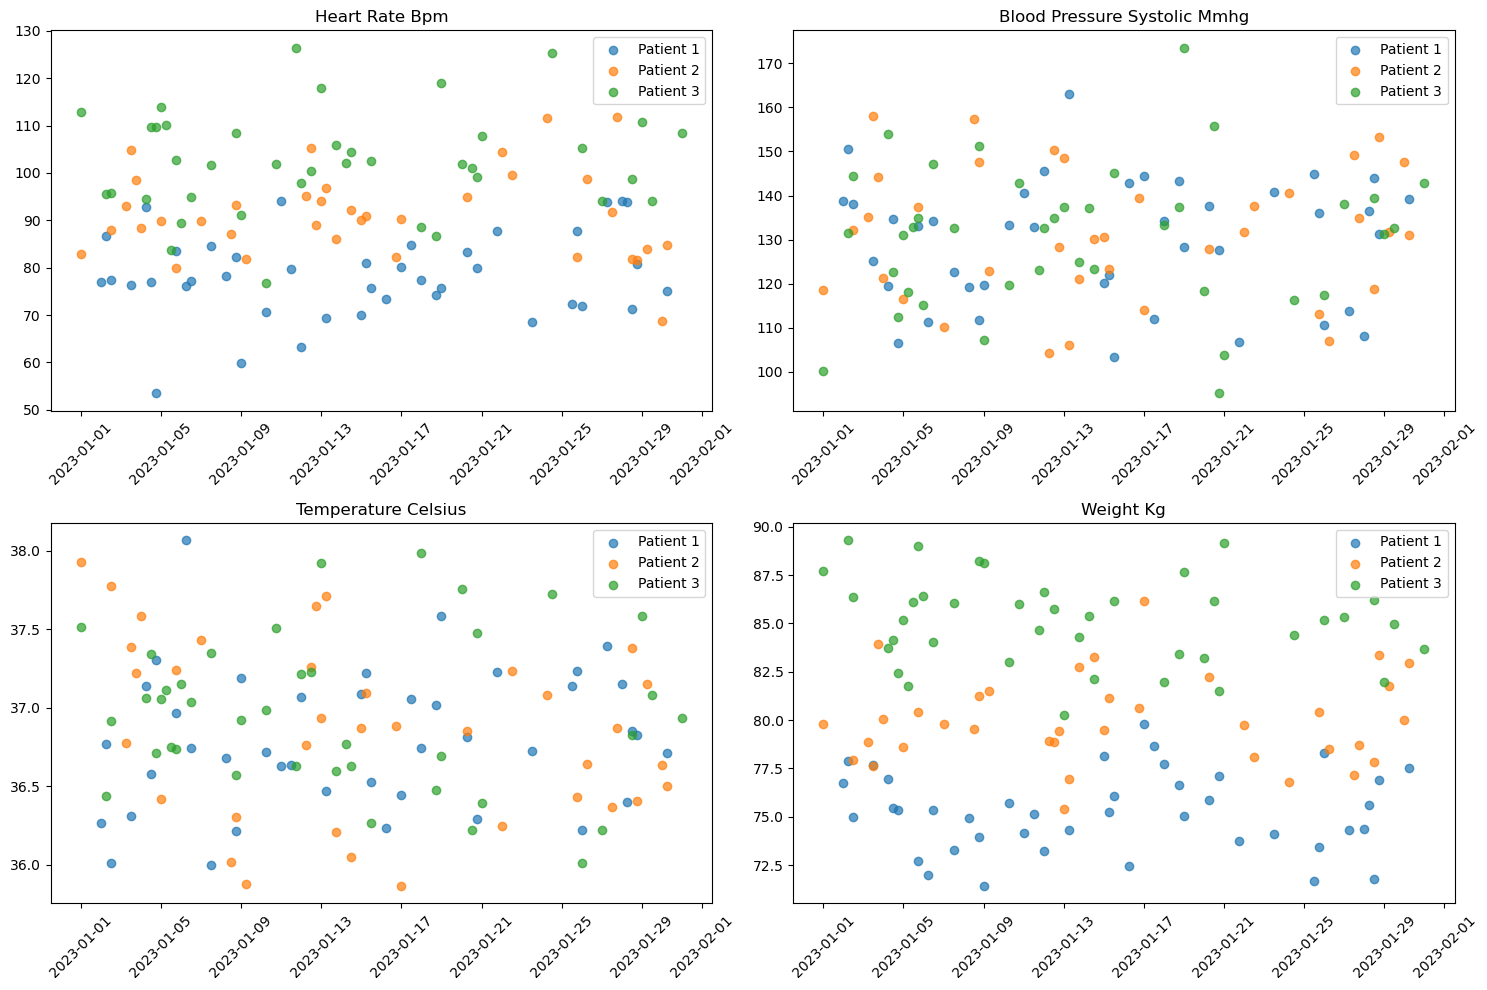

In [3]:
# Visualize the raw longitudinal data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

measurements = ['heart_rate_bpm', 'blood_pressure_systolic_mmHg', 'temperature_celsius', 'weight_kg']

for i, measurement in enumerate(measurements):
    for patient_id in raw_data['patient_id'].unique():
        patient_data = raw_data[raw_data['patient_id'] == patient_id]
        axes[i].scatter(patient_data['timestamp'], patient_data[measurement], 
                       label=f'Patient {patient_id}', alpha=0.7)
    
    axes[i].set_title(measurement.replace('_', ' ').title())
    axes[i].legend()
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 1. Unit Normalization

Unit normalization is essential when combining measurements with different scales and units. We'll demonstrate both min-max normalization and z-score standardization.

In [4]:
# Prepare data for normalization (excluding non-numeric columns)
numeric_columns = ['heart_rate_bpm', 'blood_pressure_systolic_mmHg', 'temperature_celsius', 'weight_kg']
normalization_data = raw_data.copy()

print("Original data statistics:")
print(normalization_data[numeric_columns].describe())

Original data statistics:
       heart_rate_bpm  blood_pressure_systolic_mmHg  temperature_celsius  \
count      116.000000                    116.000000           116.000000   
mean        90.416624                    130.373233            36.876032   
std         13.883255                     14.890955             0.497549   
min         53.448240                     95.109730            35.866279   
25%         80.586555                    119.431691            36.497485   
50%         89.970396                    132.393936            36.853832   
75%         99.811820                    139.675203            37.222712   
max        126.435716                    173.548903            38.067211   

        weight_kg  
count  116.000000  
mean    80.031644  
std      4.640008  
min     71.423007  
25%     76.517937  
50%     79.759754  
75%     83.798081  
max     89.310479  


Let's apply min-max normalization to scale all values between 0 and 1. This is useful when we want to preserve the relative relationships while ensuring all features have the same scale.

In [5]:
# Apply Min-Max normalization
scaler_minmax = MinMaxScaler()
normalized_minmax = normalization_data.copy()
normalized_minmax[numeric_columns] = scaler_minmax.fit_transform(normalization_data[numeric_columns])

print("Min-Max normalized data statistics:")
print(normalized_minmax[numeric_columns].describe())

Min-Max normalized data statistics:
       heart_rate_bpm  blood_pressure_systolic_mmHg  temperature_celsius  \
count      116.000000                    116.000000           116.000000   
mean         0.506503                      0.449565             0.458784   
std          0.190214                      0.189841             0.226063   
min          0.000000                      0.000000             0.000000   
25%          0.371822                      0.310074             0.286790   
50%          0.500389                      0.475326             0.448698   
75%          0.635227                      0.568153             0.616300   
max          1.000000                      1.000000             1.000000   

        weight_kg  
count  116.000000  
mean     0.481266  
std      0.259400  
min      0.000000  
25%      0.284832  
50%      0.466066  
75%      0.691829  
max      1.000000  


Now let's apply z-score standardization, which transforms data to have zero mean and unit variance. This is particularly useful when dealing with normally distributed medical measurements.

In [6]:
# Apply Z-score standardization
scaler_standard = StandardScaler()
normalized_zscore = normalization_data.copy()
normalized_zscore[numeric_columns] = scaler_standard.fit_transform(normalization_data[numeric_columns])

print("Z-score standardized data statistics:")
print(normalized_zscore[numeric_columns].describe())

Z-score standardized data statistics:
       heart_rate_bpm  blood_pressure_systolic_mmHg  temperature_celsius  \
count    1.160000e+02                  1.160000e+02         1.160000e+02   
mean    -6.527346e-16                 -5.493690e-16         1.521496e-14   
std      1.004338e+00                  1.004338e+00         1.004338e+00   
min     -2.674356e+00                 -2.378390e+00        -2.038261e+00   
25%     -7.111240e-01                 -7.379655e-01        -7.641252e-01   
50%     -3.228088e-02                  1.362888e-01        -4.481218e-02   
75%      6.796645e-01                  6.273826e-01         6.997994e-01   
max      2.605683e+00                  2.912035e+00         2.404482e+00   

          weight_kg  
count  1.160000e+02  
mean  -3.181363e-15  
std    1.004338e+00  
min   -1.863356e+00  
25%   -7.605484e-01  
50%   -5.885096e-02  
75%    8.152524e-01  
max    2.008421e+00  


Let's visualize the effect of different normalization techniques on our data distribution.

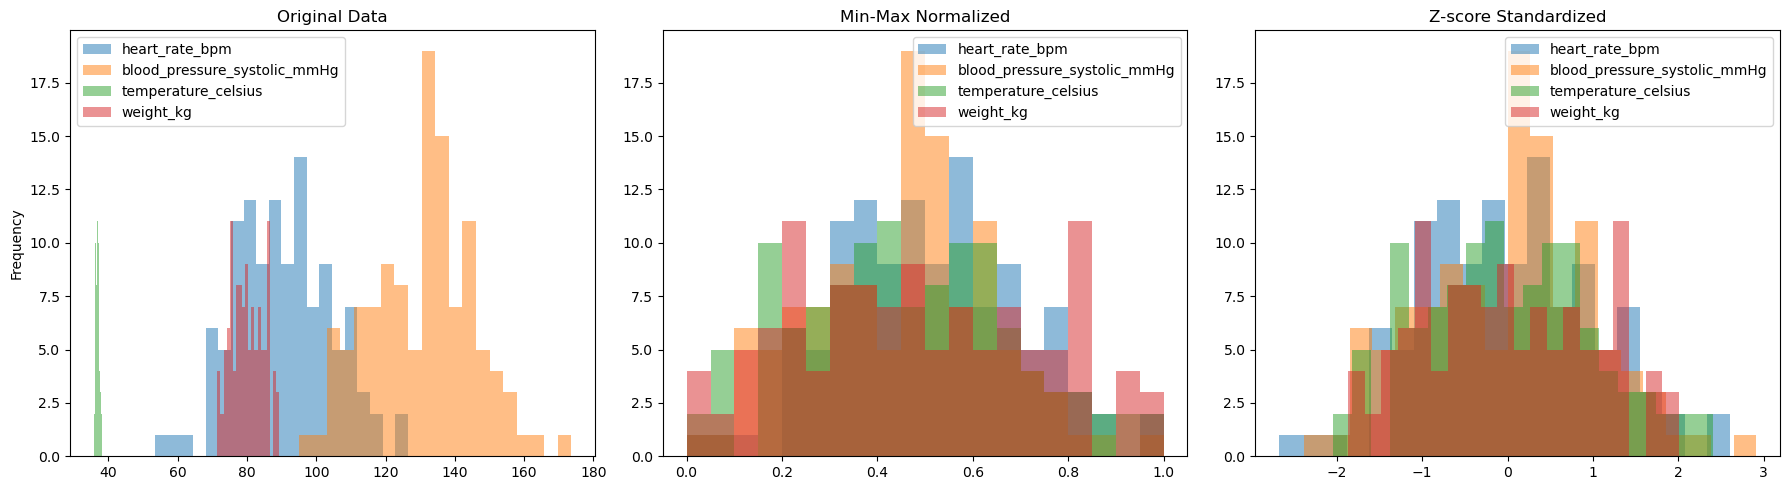

In [7]:
# Compare normalization techniques
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original data
for col in numeric_columns:
    axes[0].hist(normalization_data[col], alpha=0.5, label=col, bins=20)
axes[0].set_title('Original Data')
axes[0].legend()
axes[0].set_ylabel('Frequency')

# Min-Max normalized
for col in numeric_columns:
    axes[1].hist(normalized_minmax[col], alpha=0.5, label=col, bins=20)
axes[1].set_title('Min-Max Normalized')
axes[1].legend()

# Z-score standardized
for col in numeric_columns:
    axes[2].hist(normalized_zscore[col], alpha=0.5, label=col, bins=20)
axes[2].set_title('Z-score Standardized')
axes[2].legend()

plt.tight_layout()
plt.show()

## 2. Time Alignment

Time alignment involves synchronizing measurements from different sources or patients to a common time reference. We'll demonstrate aligning data to the earliest timestamp.

In [8]:
# Time alignment - align all patients to a common time reference
def align_timestamps(data, reference_time=None):
    aligned_data = data.copy()
    
    if reference_time is None:
        reference_time = data['timestamp'].min()
    
    # Calculate time difference in hours from reference time
    aligned_data['time_from_start_hours'] = (aligned_data['timestamp'] - reference_time).dt.total_seconds() / 3600
    
    return aligned_data, reference_time

aligned_data, ref_time = align_timestamps(raw_data)

print(f"Reference time: {ref_time}")
print(f"Time range: {aligned_data['time_from_start_hours'].min():.1f} to {aligned_data['time_from_start_hours'].max():.1f} hours")
aligned_data[['patient_id', 'timestamp', 'time_from_start_hours', 'heart_rate_bpm']].head()

Reference time: 2023-01-01 00:00:00
Time range: 0.0 to 720.0 hours


,patient_id,timestamp,time_from_start_hours,heart_rate_bpm
0,1,2023-01-02 00:00:00,24.0,76.907115
1,1,2023-01-02 06:00:00,30.0,86.731255
2,1,2023-01-02 12:00:00,36.0,77.433698
3,1,2023-01-03 12:00:00,60.0,76.321743
4,1,2023-01-04 06:00:00,78.0,92.737336


Let's visualize how the time alignment affects our data representation, showing measurements as a function of time from the common reference point.

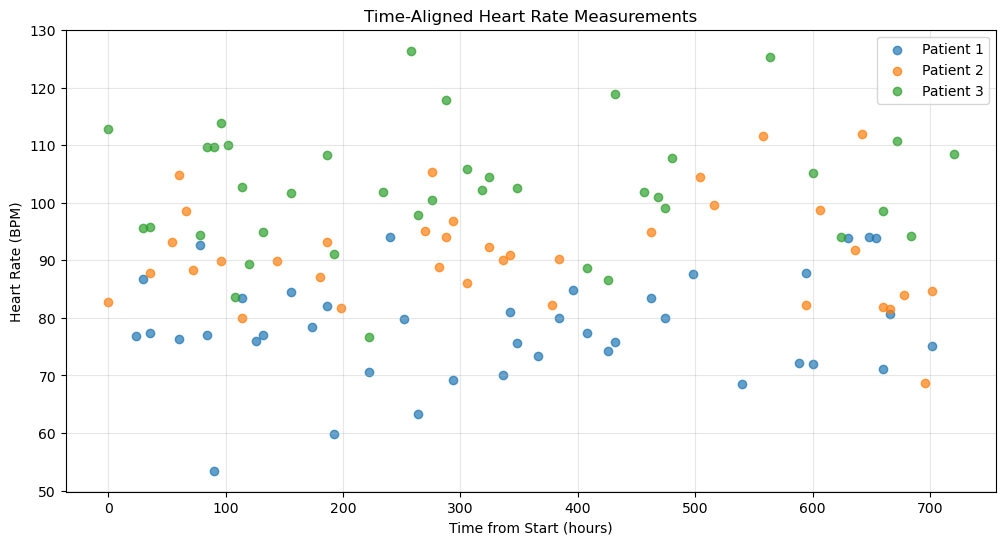

In [9]:
# Visualize time-aligned data
plt.figure(figsize=(12, 6))

for patient_id in aligned_data['patient_id'].unique():
    patient_data = aligned_data[aligned_data['patient_id'] == patient_id]
    plt.scatter(patient_data['time_from_start_hours'], patient_data['heart_rate_bpm'], 
               label=f'Patient {patient_id}', alpha=0.7)

plt.xlabel('Time from Start (hours)')
plt.ylabel('Heart Rate (BPM)')
plt.title('Time-Aligned Heart Rate Measurements')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 3. Resampling

Resampling involves converting irregular time series data to regular intervals. We'll demonstrate both upsampling (interpolation) and downsampling (aggregation) techniques.

In [10]:
# Resampling - convert to regular intervals
def resample_patient_data(patient_data, freq='6H', method='linear'):
    """
    Resample patient data to regular intervals
    freq: pandas frequency string (e.g., '6H' for 6 hours)
    method: interpolation method ('linear', 'nearest', 'cubic')
    """
    # Set timestamp as index
    patient_data_indexed = patient_data.set_index('timestamp')
    
    # Resample to regular intervals and interpolate
    resampled = patient_data_indexed.resample(freq).mean()
    
    # Interpolate missing values
    for col in numeric_columns:
        if col in resampled.columns:
            resampled[col] = resampled[col].interpolate(method=method)
    
    # Reset index and add patient_id back
    resampled = resampled.reset_index()
    resampled['patient_id'] = patient_data['patient_id'].iloc[0]
    
    return resampled

# Resample data for each patient
resampled_data_list = []
for patient_id in aligned_data['patient_id'].unique():
    patient_data = aligned_data[aligned_data['patient_id'] == patient_id]
    resampled_patient = resample_patient_data(patient_data, freq='6H')
    resampled_data_list.append(resampled_patient)

resampled_data = pd.concat(resampled_data_list, ignore_index=True)

print(f"Original data points: {len(aligned_data)}")
print(f"Resampled data points: {len(resampled_data)}")
resampled_data.head()

Original data points: 116
Resampled data points: 353


,timestamp,patient_id,heart_rate_bpm,blood_pressure_systolic_mmHg,temperature_celsius,weight_kg,time_from_start_hours
0,2023-01-02 00:00:00,1,76.907115,138.847439,36.266179,76.743828,24.0
1,2023-01-02 06:00:00,1,86.731255,150.599074,36.772931,77.874713,30.0
2,2023-01-02 12:00:00,1,77.433698,138.103841,36.015064,75.014613,36.0
3,2023-01-02 18:00:00,1,77.155709,134.862172,36.089826,75.676400,NaN
4,2023-01-03 00:00:00,1,76.877720,131.620503,36.164587,76.338188,NaN


Let's compare the original irregular data with the resampled regular interval data to see the effect of interpolation.

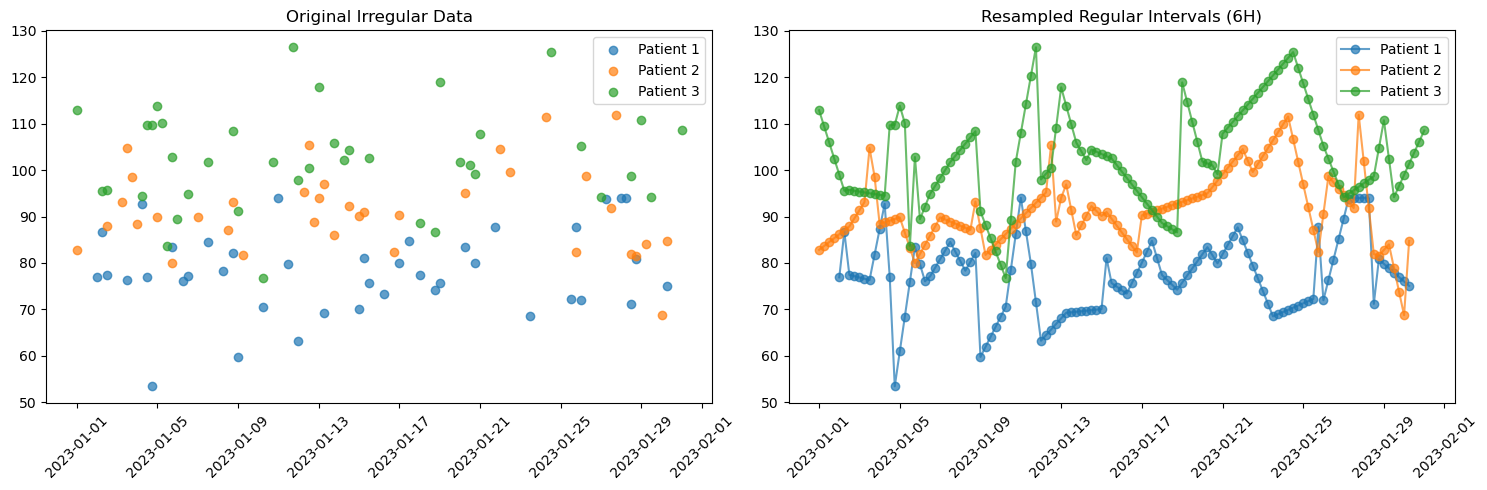

In [11]:
# Compare original vs resampled data
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Original irregular data
for patient_id in aligned_data['patient_id'].unique():
    patient_data = aligned_data[aligned_data['patient_id'] == patient_id]
    axes[0].scatter(patient_data['timestamp'], patient_data['heart_rate_bpm'], 
                   label=f'Patient {patient_id}', alpha=0.7)

axes[0].set_title('Original Irregular Data')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# Resampled regular data
for patient_id in resampled_data['patient_id'].unique():
    patient_data = resampled_data[resampled_data['patient_id'] == patient_id]
    axes[1].plot(patient_data['timestamp'], patient_data['heart_rate_bpm'], 
                'o-', label=f'Patient {patient_id}', alpha=0.7)

axes[1].set_title('Resampled Regular Intervals (6H)')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 4. Windowing

Windowing involves creating overlapping or non-overlapping time windows for analysis. This is crucial for feature extraction and temporal pattern analysis in longitudinal data.

In [12]:
# Windowing - create time windows for analysis
def create_time_windows(data, window_size_hours=24, overlap_hours=12):
    """
    Create overlapping time windows from longitudinal data
    window_size_hours: size of each window in hours
    overlap_hours: overlap between consecutive windows in hours
    """
    windows = []
    
    for patient_id in data['patient_id'].unique():
        patient_data = data[data['patient_id'] == patient_id].sort_values('timestamp')
        
        if len(patient_data) == 0:
            continue
            
        start_time = patient_data['timestamp'].min()
        end_time = patient_data['timestamp'].max()
        
        current_window_start = start_time
        window_id = 0
        
        while current_window_start + timedelta(hours=window_size_hours) <= end_time:
            window_end = current_window_start + timedelta(hours=window_size_hours)
            
            # Extract data within the window
            window_data = patient_data[
                (patient_data['timestamp'] >= current_window_start) & 
                (patient_data['timestamp'] < window_end)
            ].copy()
            
            if len(window_data) > 0:
                # Calculate window statistics
                window_stats = {
                    'patient_id': patient_id,
                    'window_id': window_id,
                    'window_start': current_window_start,
                    'window_end': window_end,
                    'n_measurements': len(window_data)
                }
                
                # Add statistics for each measurement
                for col in numeric_columns:
                    if col in window_data.columns:
                        window_stats[f'{col}_mean'] = window_data[col].mean()
                        window_stats[f'{col}_std'] = window_data[col].std()
                        window_stats[f'{col}_min'] = window_data[col].min()
                        window_stats[f'{col}_max'] = window_data[col].max()
                
                windows.append(window_stats)
            
            # Move to next window
            current_window_start += timedelta(hours=window_size_hours - overlap_hours)
            window_id += 1
    
    return pd.DataFrame(windows)

# Create 24-hour windows with 12-hour overlap
windowed_data = create_time_windows(resampled_data, window_size_hours=24, overlap_hours=12)

print(f"Created {len(windowed_data)} windows from {len(resampled_data)} data points")
windowed_data.head()

Created 171 windows from 353 data points


,patient_id,window_id,window_start,window_end,n_measurements,heart_rate_bpm_mean,heart_rate_bpm_std,heart_rate_bpm_min,heart_rate_bpm_max,blood_pressure_systolic_mmHg_mean,...,blood_pressure_systolic_mmHg_min,blood_pressure_systolic_mmHg_max,temperature_celsius_mean,temperature_celsius_std,temperature_celsius_min,temperature_celsius_max,weight_kg_mean,weight_kg_std,weight_kg_min,weight_kg_max
0,1,0,2023-01-02 00:00:00,2023-01-03 00:00:00,4,79.556944,4.787708,76.907115,86.731255,140.603132,...,134.862172,150.599074,36.286000,0.341265,36.015064,36.772931,76.327388,1.253635,75.014613,77.874713
1,1,1,2023-01-02 12:00:00,2023-01-03 12:00:00,4,77.016715,0.358882,76.599732,77.433698,133.241338,...,128.378834,138.103841,36.127206,0.096516,36.015064,36.239348,76.007294,0.854364,75.014613,76.999975
2,1,2,2023-01-03 00:00:00,2023-01-04 00:00:00,4,77.898201,2.606838,76.321743,81.793607,127.100062,...,123.263747,131.620503,36.326808,0.185264,36.164587,36.589185,77.108309,0.582168,76.338188,77.661763
3,1,3,2023-01-03 12:00:00,2023-01-04 12:00:00,4,84.529539,7.064147,76.321743,92.737336,122.327038,...,119.516911,125.137165,36.726723,0.355121,36.314110,37.139337,77.319084,0.294931,76.976405,77.661763
4,1,4,2023-01-04 00:00:00,2023-01-05 00:00:00,4,77.632880,17.379427,53.448240,92.737336,120.575109,...,106.656897,134.736301,36.972123,0.318223,36.580203,37.304691,76.249554,0.976735,75.352362,77.204858


Let's visualize the windowed data to show how statistical features are extracted from each time window.

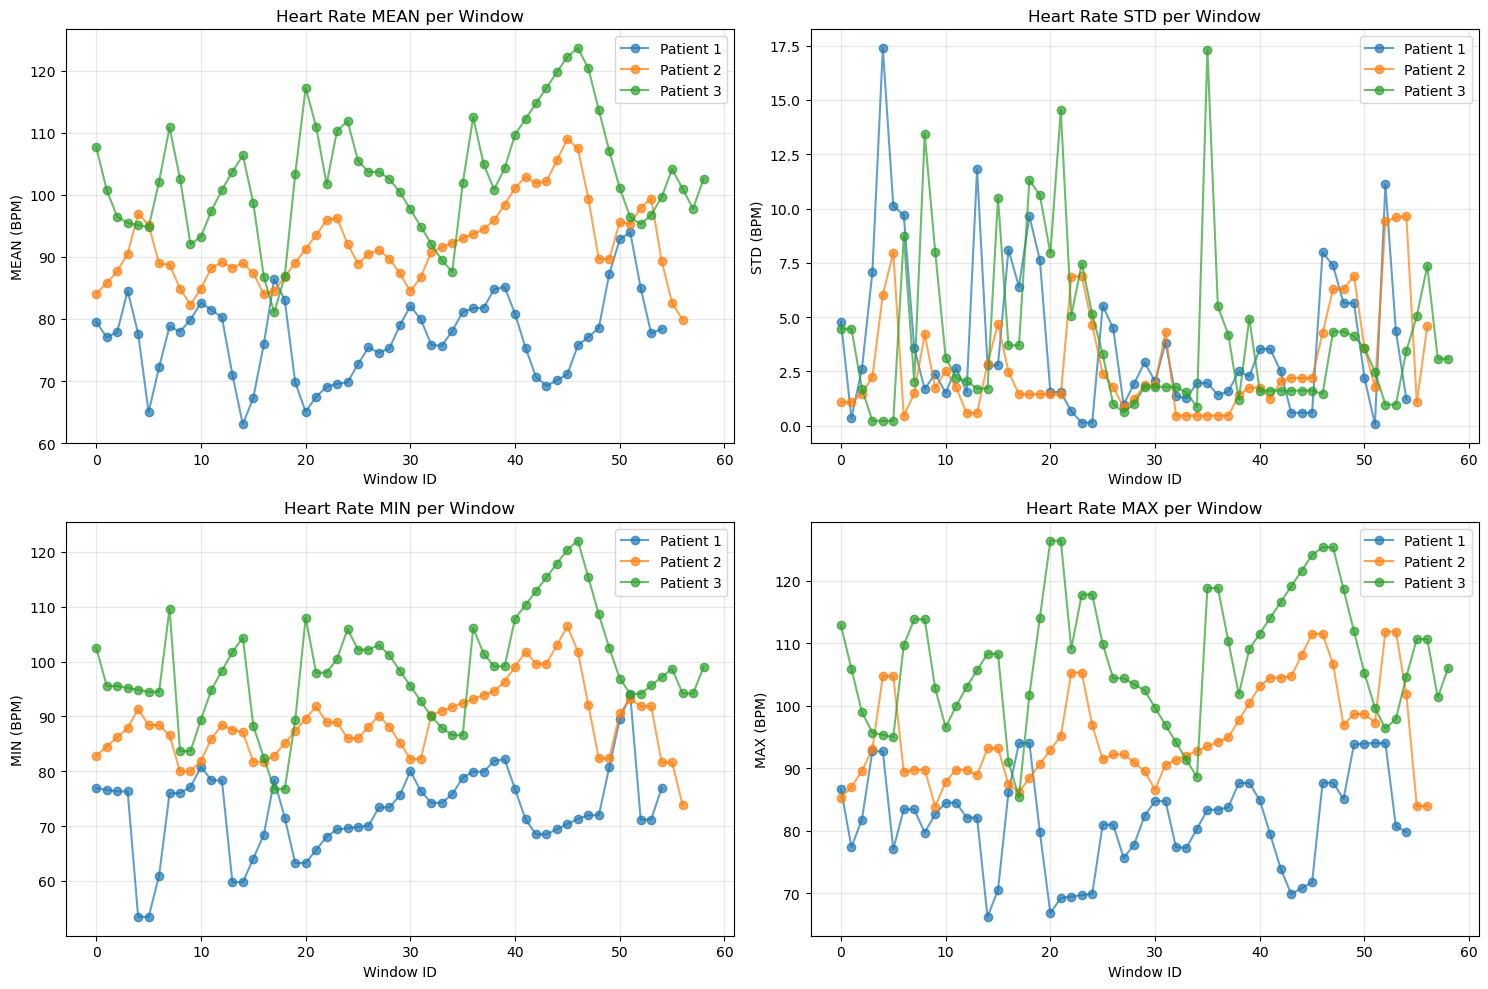

In [13]:
# Visualize windowed statistics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

statistics = ['mean', 'std', 'min', 'max']
measurement = 'heart_rate_bpm'

for i, stat in enumerate(statistics):
    col_name = f'{measurement}_{stat}'
    
    for patient_id in windowed_data['patient_id'].unique():
        patient_windows = windowed_data[windowed_data['patient_id'] == patient_id]
        axes[i].plot(patient_windows['window_id'], patient_windows[col_name], 
                    'o-', label=f'Patient {patient_id}', alpha=0.7)
    
    axes[i].set_title(f'Heart Rate {stat.upper()} per Window')
    axes[i].set_xlabel('Window ID')
    axes[i].set_ylabel(f'{stat.upper()} (BPM)')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Now let's demonstrate how to combine all preprocessing steps into a complete pipeline for processing longitudinal medical data.

In [14]:
# Complete preprocessing pipeline
def preprocess_longitudinal_data(raw_data, normalization_method='zscore', 
                                resample_freq='6H', window_size_hours=24, 
                                overlap_hours=12):
    """
    Complete preprocessing pipeline for longitudinal medical data
    """
    print("Step 1: Time alignment...")
    aligned_data, ref_time = align_timestamps(raw_data)
    
    print("Step 2: Unit normalization...")
    if normalization_method == 'zscore':
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()
    
    normalized_data = aligned_data.copy()
    normalized_data[numeric_columns] = scaler.fit_transform(aligned_data[numeric_columns])
    
    print("Step 3: Resampling...")
    resampled_list = []
    for patient_id in normalized_data['patient_id'].unique():
        patient_data = normalized_data[normalized_data['patient_id'] == patient_id]
        resampled_patient = resample_patient_data(patient_data, freq=resample_freq)
        resampled_list.append(resampled_patient)
    
    resampled_data = pd.concat(resampled_list, ignore_index=True)
    
    print("Step 4: Windowing...")
    windowed_data = create_time_windows(resampled_data, window_size_hours, overlap_hours)
    
    return {
        'aligned': aligned_data,
        'normalized': normalized_data,
        'resampled': resampled_data,
        'windowed': windowed_data,
        'scaler': scaler,
        'reference_time': ref_time
    }

# Apply complete pipeline
processed_data = preprocess_longitudinal_data(raw_data)

print(f"\nPipeline completed:")
print(f"- Raw data: {len(raw_data)} measurements")
print(f"- Resampled data: {len(processed_data['resampled'])} measurements")
print(f"- Windowed features: {len(processed_data['windowed'])} windows")

Step 1: Time alignment...
Step 2: Unit normalization...
Step 3: Resampling...
Step 4: Windowing...

Pipeline completed:
- Raw data: 116 measurements
- Resampled data: 353 measurements
- Windowed features: 171 windows


Finally, let's examine the final processed features that could be used for downstream analysis or machine learning tasks.

In [15]:
# Examine the final processed features
final_features = processed_data['windowed']

# Select feature columns (exclude metadata)
feature_columns = [col for col in final_features.columns if 
                  col.endswith(('_mean', '_std', '_min', '_max'))]

print(f"Available features: {len(feature_columns)}")
print("Feature columns:")
for col in feature_columns[:8]:  # Show first 8 features
    print(f"  - {col}")
print(f"  ... and {len(feature_columns) - 8} more")

# Show feature matrix
print("\nFeature matrix shape:", final_features[feature_columns].shape)
final_features[['patient_id', 'window_id'] + feature_columns[:4]].head()

Available features: 16
Feature columns:
  - heart_rate_bpm_mean
  - heart_rate_bpm_std
  - heart_rate_bpm_min
  - heart_rate_bpm_max
  - blood_pressure_systolic_mmHg_mean
  - blood_pressure_systolic_mmHg_std
  - blood_pressure_systolic_mmHg_min
  - blood_pressure_systolic_mmHg_max
  ... and 8 more

Feature matrix shape: (171, 16)


,patient_id,window_id,heart_rate_bpm_mean,heart_rate_bpm_std,heart_rate_bpm_min,heart_rate_bpm_max
0,1,0,-0.785608,0.346351,-0.977301,-0.266606
1,1,1,-0.969372,0.025962,-0.999538,-0.939207
2,1,2,-0.905604,0.188583,-1.019648,-0.623804
3,1,3,-0.425882,0.511032,-1.019648,0.167884
4,1,4,-0.924798,1.257257,-2.674356,0.167884


## Summary

In this notebook, we covered four essential preprocessing techniques for longitudinal medical data:

1. **Unit Normalization**: We demonstrated min-max scaling and z-score standardization to handle measurements with different units and scales
2. **Time Alignment**: We aligned timestamps to a common reference point to enable comparison across patients
3. **Resampling**: We converted irregular time series to regular intervals using interpolation
4. **Windowing**: We created overlapping time windows and extracted statistical features for analysis

These techniques are fundamental for preparing longitudinal medical data for integration, analysis, and machine learning applications.

## Exercise

Using the techniques learned in this notebook, complete the following tasks:

1. **Generate new synthetic data**: Create longitudinal data for 5 patients over 60 days with measurements including heart rate, blood pressure, temperature, and glucose levels (mg/dL with values around 100±20).

2. **Apply different normalization techniques**: Compare the results of min-max normalization, z-score standardization, and robust scaling (using `RobustScaler` from sklearn) on your data.

3. **Experiment with resampling**: Try different resampling frequencies (2H, 12H, 24H) and interpolation methods ('linear', 'cubic', 'nearest'). Visualize the differences.

4. **Custom windowing**: Create a windowing function that extracts additional features such as slope (trend), area under the curve, and peak detection for each window.

5. **Pipeline evaluation**: Create a function that evaluates the quality of your preprocessing pipeline by calculating metrics such as data coverage (percentage of time with data), interpolation error, and feature correlation before and after processing.

Submit your solution showing the preprocessed data characteristics, visualizations comparing different approaches, and your evaluation metrics.